# Simulation of Elzerman readout

In this notebook we simulate the measurement traces generated by an electron tunneling on or off a quantum dot, using a continuous-time Markov model. A Markov chain (according to Wikipedia) is a stochastic model describing a sequence of possible events in which the provavility of each event depends only on the state attained in the previous event. For more information: https://www.probabilitycourse.com/chapter11/11_3_1_introduction.php and https://vknight.org/unpeudemath/code/2015/08/01/simulating_continuous_markov_chains.html 

This simulation is used to investigate ways to analyse the data of random telegraph signal (RTS) and Elzerman readout. For the latter we also calculate the readout fidelity for our model.

In [1]:
import warnings
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy

import qtt
from qtt.algorithms.random_telegraph_signal import generate_RTS_signal
from qtt.algorithms.markov_chain import ContinuousTimeMarkovModel, generate_traces
from qtt.algorithms.random_telegraph_signal import tunnelrates_RTS
from qtt.algorithms.random_telegraph_signal import fit_double_gaussian

def plot_vertical_line(value, label, color='c'):
    vline = plt.gca().axvline(value, label=label); vline.set_color(color)
    vline.set_alpha(0.5)
    vline.set_linestyle(':')
    
def plot_double_gaussian_fit(result_dict, xdata):
    plt.plot(xdata, qtt.algorithms.functions.gaussian(xdata, *result_dict['left']), 'g', label='left' )
    _=plt.plot(xdata, qtt.algorithms.functions.gaussian(xdata, *result_dict['right']), 'r', label='right' )
np.random.seed(1)

## Random telegraph signal

We start with a model for a random telegraph signal. This model is valid for an electron tunneling into and out of a quantum dot with zero magnetic field. The figure shows a measurement signal which is typical for RTS.

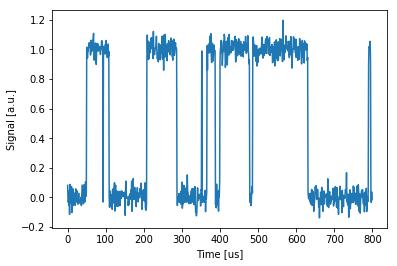

In [2]:
model_unit = 1e-6 # we work with microseconds as the base unit
rate_up = 15e3 # kHz
rate_down = 25e3 # kHz
rts_model = ContinuousTimeMarkovModel(['zero', 'one'], [rate_up*model_unit,rate_down*model_unit], np.array([[0.,1],[1,0]]) )        
      
rts_data = generate_traces(rts_model, number_of_sequences=1, length=500000, std_gaussian_noise=.05, delta_time=1)
    
plt.figure(100); plt.clf()
plt.plot(1e6*model_unit*np.arange(800), rts_data.T[0:800,:])
plt.xlabel('Time [us]')
_=plt.ylabel('Signal [a.u.]')

We analyse the signal to determine the tunnel rates and the separation between the two levels.

Fit parameters double gaussian:
 mean down: 0.000 counts, mean up:1.000 counts, std down: 0.050 counts, std up:0.050 counts
Separation between peaks gaussians: 9.993 std
Split between two levels: 0.500
 _create_histogram level down: nbins 63, 11
 _create_histogram level up: nbins 60, 7
Tunnel rate down: 14.4 kHz
Tunnel rate up: 24.3 kHz


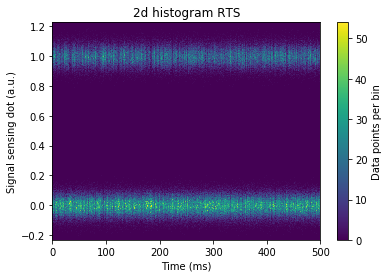

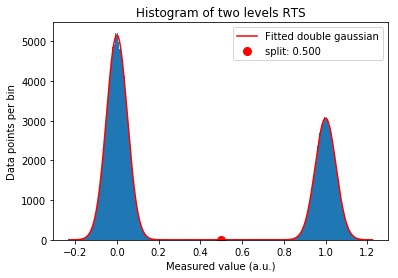

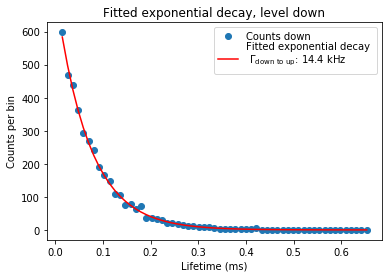

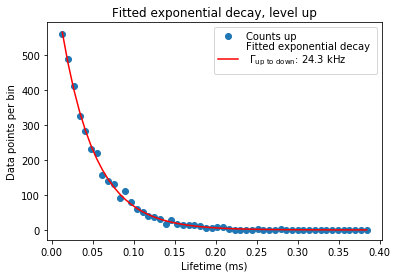

In [3]:
samplerate=1e6
tunnelrate_dn, tunnelrate_up, results = tunnelrates_RTS(rts_data.flatten(), samplerate=samplerate, min_sep = 1.0, max_sep=2222, min_duration = 10, fig=1, verbose=1)

### More efficient calculation of tunnel rates

The tunnel rates are calculated by fitting an exponential to a histogram of segment lengths.
The mean segment length contains roughly the same information. Fitting the exponantial is more accurate when the tunnelrate approximates the sampling rate. Calculating the mean segment length is more robust for low number of datapoints.

Comparing the performance of the two analysis methods, varying the tunnelrates and lowering the number of datapoints. Blue: fitted tunnelrate, red: 1 / mean segment length.

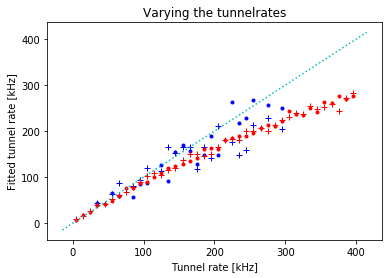

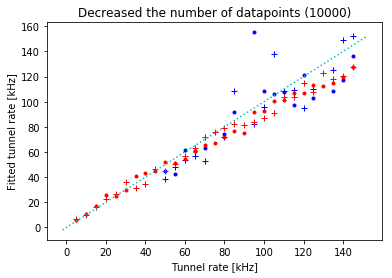

In [4]:
def generate_RTS_results(tunnel_rate, model_unit, length):
    rts_model = ContinuousTimeMarkovModel(['down', 'up'], [tunnel_rate*model_unit,tunnel_rate*model_unit], np.array([[0.,1],[1,0]]) )        
        
    rtsdata = generate_traces(rts_model, number_of_sequences=1, length=10000, std_gaussian_noise=.15)[0]
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        tunnelrate_dn, tunnelrate_up, results = tunnelrates_RTS(rtsdata, samplerate=samplerate, min_sep = 1.0, max_sep=2222, min_duration = 10, num_bins = 40, plungers=[], fig=0, verbose=0)
    return tunnelrate_dn, tunnelrate_up, results

def plot_RTS_results(results, model_unit, fig):
    tunnelrate_dn = results['tunnelrate_down_exponential_fit']
    tunnelrate_up = results['tunnelrate_up_exponential_fit']
    plt.figure(fig)
    if tunnelrate_dn is not None:
        plt.plot(tunnel_rate/1e3, tunnelrate_dn, '.b')
        plt.plot(tunnel_rate/1e3, tunnelrate_up, '+b')
    
    x_factor = 1e-3
    y_factor = (1./model_unit)*x_factor
    plt.plot(tunnel_rate*x_factor, y_factor/(samplerate*results['down_segments']['mean']), '.r')
    plt.plot(tunnel_rate*x_factor, y_factor/(samplerate*results['up_segments']['mean']), '+r')

samplerate = 1e6

plt.figure(1002); plt.clf(); plt.xlabel('Tunnel rate [kHz]'); plt.ylabel('Fitted tunnel rate [kHz]')
for jj, tunnel_rate in enumerate(np.arange(5, 405, 10)*1e3): #varying the tunnelrate from 5 to 400 kHz
    tunnelrate_dn, tunnelrate_up, results = generate_RTS_results(tunnel_rate, model_unit, length = 155000) 
    plot_RTS_results(results, model_unit, fig = 1002)

plt.figure(1002)
qtt.pgeometry.plot2Dline([1,-1,0], ':c', label='')
plt.title('Varying the tunnelrates')

plt.figure(1010); plt.clf(); plt.xlabel('Tunnel rate [kHz]'); plt.ylabel('Fitted tunnel rate [kHz]')
for jj, tunnel_rate in enumerate(np.arange(5, 150, 5)*1e3):    
    tunnelrate_dn, tunnelrate_up, results = generate_RTS_results(tunnel_rate, model_unit, length = 10000)
    plot_RTS_results(results, model_unit, fig = 1010)

plt.figure(1010)
qtt.pgeometry.plot2Dline([1,-1,0], ':c', label='')
_ = plt.title('Decreased the number of datapoints (10000)')

## Elzerman readout

We model Elzerman readout with a Markov model with three states: empty, dot filled with a spin-up electron, dot filled with a spin-dot electron. The transitions possible are tunneling of a spin-up or spin-down electron out of the system, tunneling from an electron into the down state and decay of spin-up to spin-down (T1 decay).

In [5]:
model_unit = 1e-6 # we work with microseconds as the baseunit

gamma_up_out = 10e3
gamma_down_out = .1e3
gamma_empty_down = 2e3
T1 = 3e-3 # [s]
gamma_up_down = 1./T1 

G = np.array( [[-gamma_down_out, 0, gamma_down_out], [gamma_up_down, -(gamma_up_down+gamma_up_out), gamma_up_out], [gamma_empty_down, 0, -gamma_empty_down]] ).T
holding_parameters = -np.diag(G).reshape( (-1,1))
jump_chain= (1./holding_parameters.T)*G
jump_chain[np.diag_indices(G.shape[0])]=0

elzerman_model = ContinuousTimeMarkovModel(['spin-down', 'spin-up', 'empty'], holding_parameters*model_unit, jump_chain )
print(elzerman_model)

ContinuousTimeMarkovModel(id=0x23e88916160, states=['spin-down', 'spin-up', 'empty'], generator=[[-1.00000000e-04  3.33333333e-04  2.00000000e-03]
 [ 0.00000000e+00 -1.03333333e-02  0.00000000e+00]
 [ 1.00000000e-04  1.00000000e-02 -2.00000000e-03]])


We generate a number of traces with the model. We shown the generated states (first plot) and the corresponding signal of the charge sensor (second plot). We calculate the signal of the charge sensor from the states with the `sensor_values` map and add noise to the signal. This gives us the opportunity to compare the states as simulated (dot empty, dot occupied with spin-up electron, dot occupied with spin-down electron), with the corresponding measurement traces. 

In [6]:
sensor_values = {'spin-down': 0, 'spin-up':0, 'empty': 1}

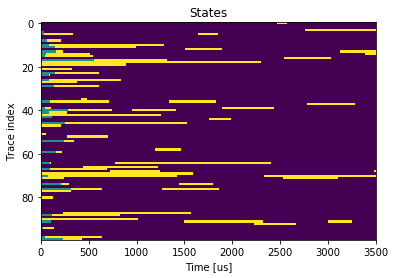

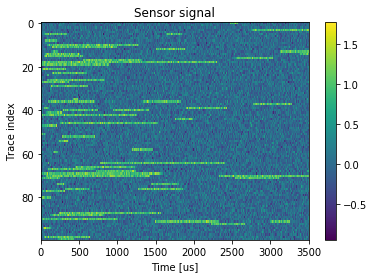

In [7]:
def generate_model_sequences(elzerman_model, sensor_values=sensor_values, std_gaussian_noise = 0.2,
                                number_of_samples=3500, number_of_traces=1000, initial_state=[.5, .5, 0] ):    
    state_traces = generate_traces(elzerman_model, std_gaussian_noise=0, length=number_of_samples, initial_state=initial_state, number_of_sequences=number_of_traces)

    state_mapping=np.array([ sensor_values.get(state, np.NaN) for state in elzerman_model.states])
    traces = state_traces.copy()
    traces=np.array(state_mapping)[traces]
    if std_gaussian_noise != 0:
        traces = traces + np.random.normal(0, std_gaussian_noise, traces.size).reshape(traces.shape)

    initial_states=state_traces[:,0]
    return traces, state_traces, initial_states

traces, state_traces, initial_states = generate_model_sequences(elzerman_model, number_of_traces=300)
max_number_traces=100

plt.figure();
plt.imshow(state_traces[:max_number_traces,:])
plt.axis('tight')
plt.xlabel('Time [us]'); plt.ylabel('Trace index')
plt.title('States')

plt.figure();
plt.imshow(traces[:max_number_traces,:])
plt.axis('tight')
plt.xlabel('Time [us]'); plt.ylabel('Trace index')
plt.title('Sensor signal')
_=plt.colorbar()

We can also plot the individual traces. For reference we color the traces according to the initial-state of the traces.

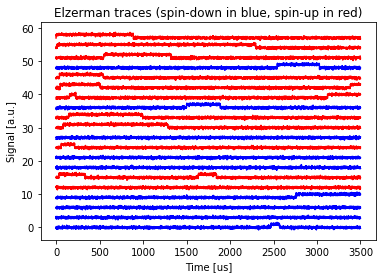

In [8]:
plt.figure();
for ii in range(20):
    offset=ii*3
    if initial_states[ii]==0:
        color='b'
    else:
        color='r'
    plt.plot(traces[ii]+offset, color=color)
plt.xlabel('Time [us]')
plt.ylabel('Signal [a.u.]')
_=plt.title('Elzerman traces (spin-down in blue, spin-up in red)')

## Determination of readout fidelity with max of trace

For each trace we termine the maximum value. We then label the traces according to whether this maximum value exceeds a given threshold.

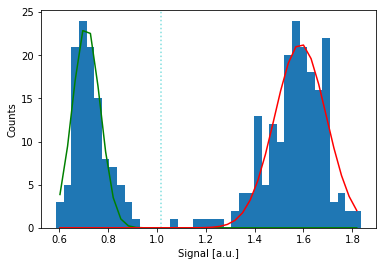

In [9]:
def elzerman_threshold(traces, number_of_bins = 40):
    """ Determine threshold for Elzerman readout """
    counts, bins = np.histogram(np.max(traces, axis=1).flatten(), bins=number_of_bins)
    bin_centres = np.array([(bins[i] + bins[i + 1]) / 2 for i in range(0, len(bins) - 1)])
    par_fit, result_dict = fit_double_gaussian(bin_centres, counts)

    result = {'readout_threshold': result_dict['split'], 'double_gaussian_fit': result_dict,
              'histogram':{'counts': counts, 'bins': bins, 'bin_centres': bin_centres}}
    return result

def plot_elzerman_threshold(results, fig=100):
    plt.figure(100); plt.clf()
    bin_centres = results['histogram']['bin_centres']
    counts = results['histogram']['counts']
    bin_centres[1]-bin_centres[0]
    plt.bar(bin_centres, counts, width=bin_centres[1]-bin_centres[0])
    plt.ylabel('Counts'); plt.xlabel('Signal [a.u.]')
    plot_vertical_line(results['readout_threshold'], label='threshold')
    
    plot_double_gaussian_fit(results['double_gaussian_fit'], bin_centres)
    
elzermann_threshold_result = elzerman_threshold(traces)
plot_elzerman_threshold(elzermann_threshold_result)

For a given readout threshold and readout length we can determine the fidelity by counting the number of traces that is correctly labelled as either up or down.

In [10]:
def calculate_fidelity(traces, initial_states, readout_threshold, readout_length):
    traces_smooth = scipy.ndimage.filters.convolve(traces, np.array([[1,1,1.]])/3, mode='nearest')      
    measured_states = np.max(traces_smooth[:, :readout_length], axis=1)>readout_threshold
    F= np.sum(initial_states==measured_states) /   measured_states.size 
    return F

readout_threshold=elzermann_threshold_result['readout_threshold']

F=calculate_fidelity(traces, initial_states, readout_threshold, 800)    
print('readout fidelity F %.2f' % F)

readout fidelity F 0.91


The optimal fidelity is a trade-off between longer measurement (so that a spin-up state can tunnel out) and shorter measurement (no accidental tunneling out of the ground state, or decay from spin up to spin down).

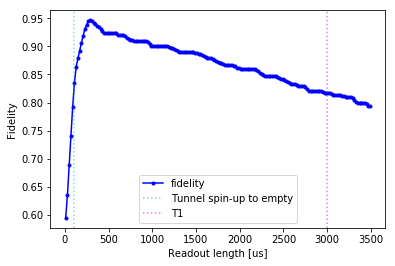

In [12]:
readout_lengths=np.arange(10, traces.shape[1], 20)
fidelities=np.zeros(readout_lengths.size)
for ii, readout_length in enumerate(readout_lengths):
    fidelities[ii]=calculate_fidelity(traces, initial_states, readout_threshold, readout_length)    

fidelities=qtt.algorithms.generic.smoothImage(fidelities)
plt.figure(1000);
plt.clf()
plt.plot(readout_lengths, fidelities,'.-b', label='fidelity')
plt.xlabel('Readout length [us]')
_=plt.ylabel('Fidelity')

plot_vertical_line(1.e6/gamma_up_out, 'Tunnel spin-up to empty')
plot_vertical_line(1.e6/gamma_up_down, 'T1', 'm')
_=plt.legend(numpoints=1)

## Pauli spin blockade or readout with a resonator

Taking the maximum of the trace has the disadvantage that a lot of information from the trace is discarded. An alternative method is to take the mean of the trace (over the readout period). This does not work for Elzerman readout, as the length of the blips can be either short or long with respect to the measurement interval.

For Pauli spin-blockade (PSB) or resonator spin readout ([Rapid high-fidelity gate-based spin read-out in silicon](https://arxiv.org/abs/1901.00687)) we can average over the traces, as the signal is different for both spin-up and spin-down directly after pulsing to the measurement point.

In [13]:
model_unit = 1e-6 # we work with microseconds as the baseunit
T1 = 3e-3 # [s]
gamma_up_down = 1./T1  # Hz
gamma_down_up = 1e-5 # Hz

psb_model = ContinuousTimeMarkovModel(['spin-up', 'spin-down'], [gamma_up_down*model_unit,gamma_down_up*model_unit], np.array([[0.,1],[1,0]]) )        
print(psb_model)

ContinuousTimeMarkovModel(id=0x23e88bcd9b0, states=['spin-up', 'spin-down'], generator=[[-3.33333333e-04  1.00000000e-11]
 [ 3.33333333e-04 -1.00000000e-11]])


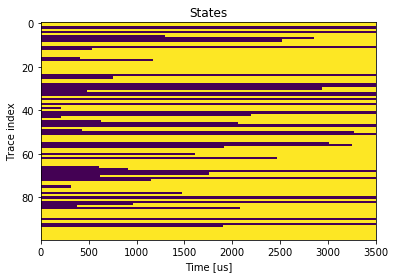

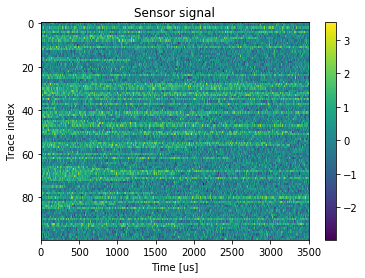

In [14]:
sensor_values = {'spin-down': 0, 'spin-up':1}
traces, state_traces, initial_states = generate_model_sequences(psb_model, sensor_values=sensor_values,
                                        std_gaussian_noise=.6, number_of_traces=300, initial_state=[0.5,0.5])
max_number_traces=100

plt.figure();
plt.imshow(state_traces[:max_number_traces,:])
plt.axis('tight')
plt.xlabel('Time [us]'); plt.ylabel('Trace index')
plt.title('States')

plt.figure();
plt.imshow(traces[:max_number_traces,:])
plt.axis('tight')
plt.xlabel('Time [us]'); plt.ylabel('Trace index')
plt.title('Sensor signal')
_=plt.colorbar()

fitted parameters : [6.71438480e+01 6.18088556e+01 2.48290027e-02 2.04288727e-02
 9.59310402e-04 1.00614575e+00]


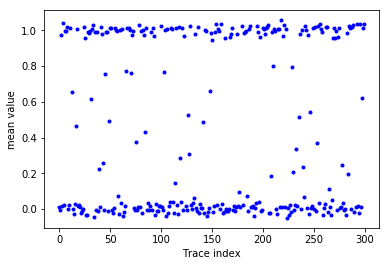

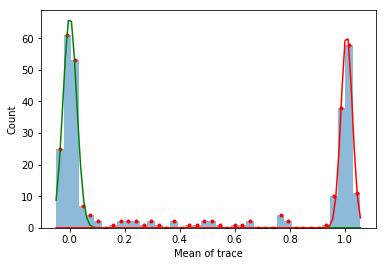

In [15]:
readout_length = 800
trace_means = np.mean(traces[:, :readout_length], axis=1)

number_of_bins = 40
counts, bins = np.histogram(trace_means, bins=number_of_bins)
bincentres = np.array([(bins[i] + bins[i + 1]) / 2 for i in range(0, len(bins) - 1)])
par_fit, result_dict = fit_double_gaussian(bincentres, counts)
print('fitted parameters : %s' % (par_fit,))

plt.figure(50); plt.clf()
plt.plot(trace_means, '.b')
plt.xlabel('Trace index'); plt.ylabel('mean value')

plt.figure(100); plt.clf()
plt.bar(bincentres, counts, width=bincentres[1]-bincentres[0], alpha=.5)
_=plt.plot(bincentres, counts, '.r')
plt.xlabel('Mean of trace'); plt.ylabel('Count')

signal_range=np.linspace(trace_means.min(), trace_means.max(), 100 )

plot_double_gaussian_fit(result_dict, signal_range)

In [17]:
psb_threshold = 0.5

In [18]:
def calculate_fidelity_mean(traces, initial_states, readout_threshold, readout_length):
    trace_means = np.mean(traces[:, :readout_length], axis=1)
    measured_states = trace_means < readout_threshold
    F= np.sum(initial_states==measured_states) /   measured_states.size 
    return F

F=calculate_fidelity_mean(traces, initial_states, psb_threshold, readout_length = 800)    
print('readout fidelity F %.2f' % F)

readout fidelity F 0.92


From the fitted double Gaussian the readout fidelity can also be determined (for details including a model where the T1 decay is taken into account, see "Rapid Single-Shot Measurement of a Singlet-Triplet Qubit", Barthel et al., 2009, https://arxiv.org/abs/0902.0227). This is usefull for real measurement data where the true spin-states of the traces are unknown.